In [102]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from tqdm.notebook import tqdm

METHOD 1:
VADER model

In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from tqdm.notebook import tqdm


In [58]:
SIA().polarity_scores('I feel happy')

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [57]:
SIA().polarity_scores('I hate DSA')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [110]:
reviews = pd.read_csv("./processed_data.csv")
reviews.shape

(100000, 12)

In [111]:
reviews.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,NaN,True,"10 23, 2014",A2C2S9BBPWTK9Y,B00CZF8B68,{'Format:': ' MP3 Music'},Suzi,"Love the movie, and especially the song!",Five Stars,1414022400,NaN
1,5.0,NaN,False,"12 31, 2015",AQR5ZB4BIJFLT,B00122Z6ZY,{'Format:': ' MP3 Music'},jackie,"Sigh, so good!",so good!,1451520000,NaN
2,5.0,NaN,True,"04 18, 2016",A3QEOGJXHI6UEG,B0186SEPNU,{'Format:': ' MP3 Music'},Irene Garcia,Love the foo fighters,Five Stars,1460937600,NaN
3,5.0,NaN,True,"12 3, 2014",A18REVWRZ4GA7M,B007JCPEVM,{'Format:': ' MP3 Music'},wendy kipp,1,Five Stars,1417564800,NaN
4,5.0,NaN,True,"02 11, 2015",A2IJCEG2J34W61,B00E67KLDE,{'Format:': ' MP3 Music'},Honest Critique,Great Song.,Five Stars,1423612800,NaN


In [71]:
res = {}
for i, row in tqdm(reviews.iterrows(),total=len(reviews)):
    text=row['reviewText']
    text=str(text)
    myid=row['reviewerID']
    res[myid]=SIA().polarity_scores(text)
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [91]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'reviewerID'})
vaders=vaders.merge(reviews, how='left')


In [94]:
#sentiment scores and metadata
vaders.head()


,reviewerID,neg,neu,pos,compound,overall,vote,verified,reviewTime,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,swn_score
0,A2C2S9BBPWTK9Y,0.0,0.323,0.677,0.636,5.0,NaN,True,"10 23, 2014",B00CZF8B68,{'Format:': ' MP3 Music'},Suzi,"Love the movie, and especially the song!",Five Stars,1414022400,NaN,"Love the movie, and especially the song!"
1,A2C2S9BBPWTK9Y,0.0,0.323,0.677,0.636,5.0,NaN,True,"10 23, 2014",B00137QMN8,{'Format:': ' MP3 Music'},Suzi,A great song!,Five Stars,1414022400,NaN,A great song!
2,A2C2S9BBPWTK9Y,0.0,0.323,0.677,0.636,5.0,NaN,True,"10 23, 2014",B00137QMN8,{'Format:': ' MP3 Music'},Suzi,A great song!,Five Stars,1414022400,NaN,A great song!
3,A2C2S9BBPWTK9Y,0.0,0.323,0.677,0.636,5.0,NaN,True,"10 23, 2014",B00HU5FDJ6,{'Format:': ' MP3 Music'},Suzi,Rihanna+Shakira= AMAZING!!,Five Stars,1414022400,NaN,Rihanna+Shakira= AMAZING!!
4,A2C2S9BBPWTK9Y,0.0,0.323,0.677,0.636,5.0,NaN,True,"10 23, 2014",B00IMRM7M2,{'Format:': ' MP3 Music'},Suzi,A beautiful Shakira song!,Five Stars,1414022400,NaN,A beautiful Shakira song!


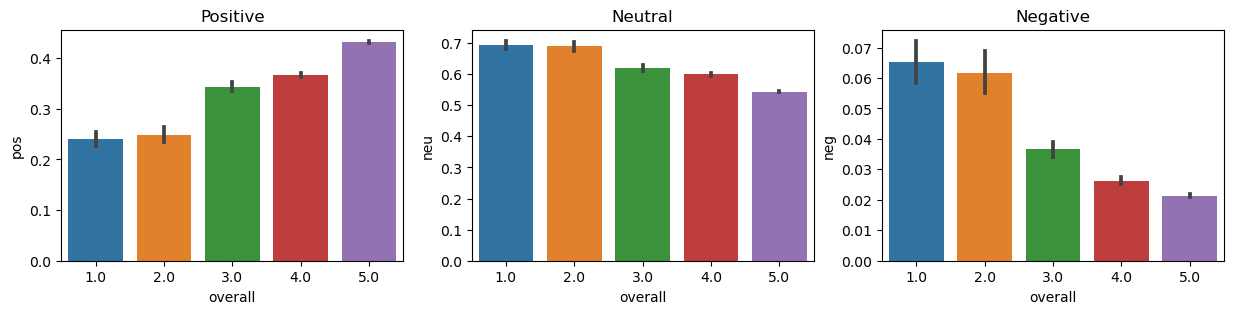

In [98]:
fig,axs=plt.subplots(1,3,figsize=(15,3))
sns.barplot(data=vaders,x='overall',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='overall',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='overall',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

Model 2:
roBERTa model from hugging face 

In [114]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [130]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [145]:
reviews=reviews.head(500)

In [128]:
example=reviews['reviewText'][14]
print(example)
SIA().polarity_scores(example)

My favorite Jim Croce love song.


{'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'compound': 0.802}

In [132]:
encoded_text=tokenizer(example, return_tensors='pt')
output=model(**encoded_text)

scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0012844958, 'roberta_neu': 0.019295095, 'roberta_pos': 0.9794205}


In [133]:
def polarity_scores_roberta(example):
    encoded_text=tokenizer(example, return_tensors='pt')
    output=model(**encoded_text)

    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [146]:
res = {}
for i, row in tqdm(reviews.iterrows(),total=len(reviews)):
    try:
        text=row['reviewText']
        text=str(text)
        myid=row['reviewerID']
        vader_result=SIA().polarity_scores(text)
        vader_result_rename={}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"]=value
        roberta_result=polarity_scores_roberta(text)
        both={**vader_result_rename,**roberta_result}
        res[myid]=both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id A2MU30JJ36LSAD
Broke for id AGAMDS21PJZPK
Broke for id A1IIUCG9TJFUWS


In [147]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'reviewerID'})
results_df=results_df.merge(reviews, how='left')


Compare Scores Between Models

In [148]:
results_df.columns

Index(['reviewerID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'overall', 'vote',
       'verified', 'reviewTime', 'asin', 'style', 'reviewerName', 'reviewText',
       'summary', 'unixReviewTime', 'image'],
      dtype='object')

/Users/lasyasandhu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


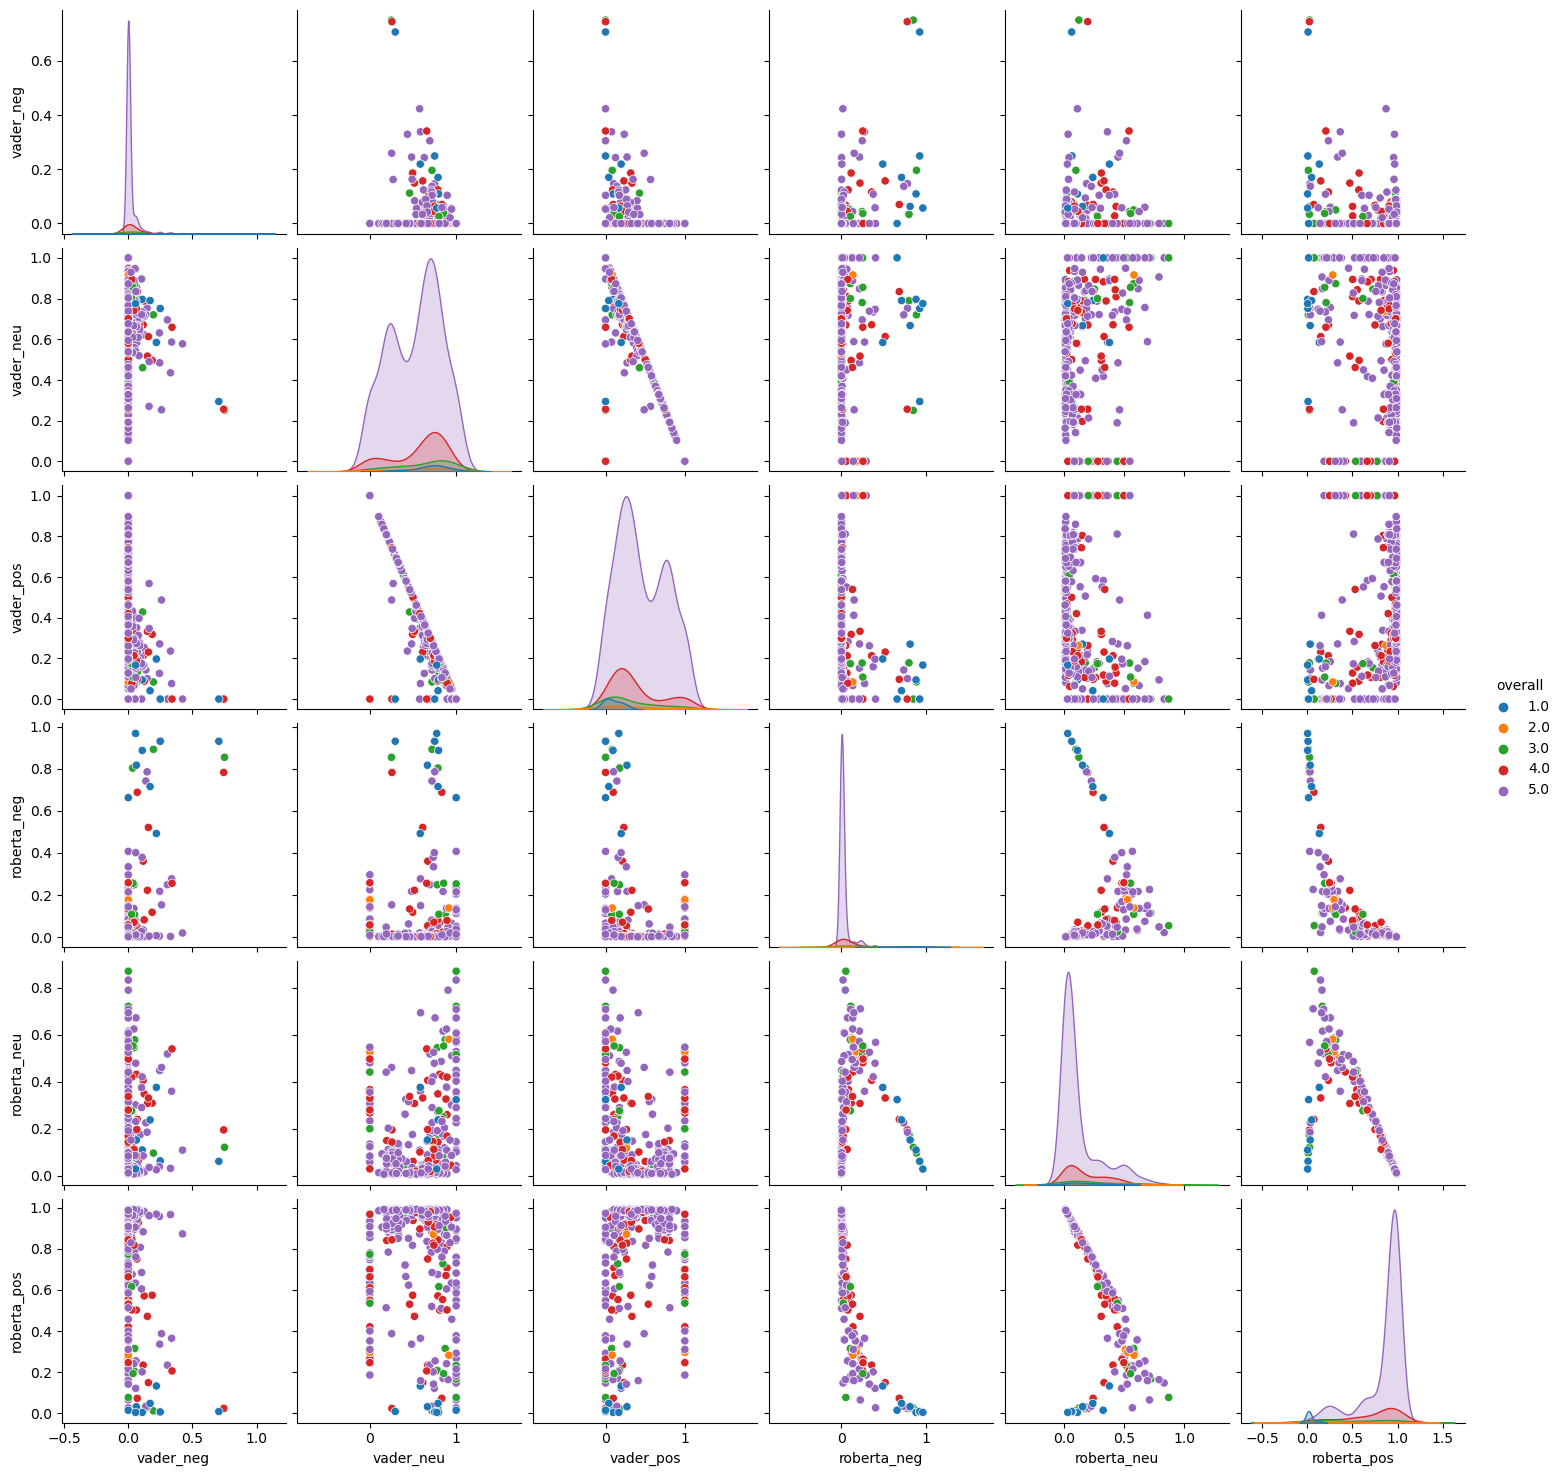

In [151]:
sns.pairplot(data=results_df,
             vars=['vader_neg','vader_neu','vader_pos','roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='overall',
             palette='tab10'
             )

Review Examples:
Positive 1 star reviews and Negative 5 star reviews

In [156]:
results_df.query('overall==1') \
    .sort_values('roberta_pos',ascending=False)['reviewText'].values[0]

'Download failed and I did not receive the product. I will be happy to review the performances once Amazon fixes the problem.'

In [157]:
results_df.query('overall==1') \
    .sort_values('vader_pos',ascending=False)['reviewText'].values[0]

"I never got the song to download in any condition that could be played. I'd like to think I'm an optimist because I keep trying to download music from Amazon. Actually I am beginning to believe that it is more stupidity than optimism."

In [159]:
results_df.query('overall==5') \
    .sort_values('roberta_neg',ascending=False)['reviewText'].values[0]

"I do not think there is one song on this album that I do not like. I am generally not a fan of the quasi country-pop crossover stars, but I wil freely admit, that in her case and this albums case, a rare exception is made. I can't even find one song I do not like better than another."

In [160]:
results_df.query('overall==5') \
    .sort_values('vader_neg',ascending=False)['reviewText'].values[0]

"Who doesn't love Prince.. It's a classic!"